In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
from datetime import date
import networkx as nx
import os
import torch
from torch import nn
import seaborn as sns
import random

#Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/data/'
file_name = 'TrainSet2014_3.pkl'
data_source = root_path+file_name

NUM_OF_VERTICES=64719 # number of vertices of the semantic net
full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start,years_delta = pickle.load( open( data_source, "rb" ) )

print('The dataset has '+str(len(full_dynamic_graph_sparse))+' edges between a total of '+str(NUM_OF_VERTICES)+ ' vertices.')

The dataset has 2278611 edges between a total of 64719 vertices.


#EDA

In [ ]:
def graph_year(fdg, year):

  NUM_OF_VERTICES = 64719
  day_origin = date(1990, 1, 1)
  day_curr = date(year, 12, 31)
  all_edges_curr = fdg[fdg[:, 2] < (day_curr - day_origin).days]

  #a = csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)]); where a[row_ind[k], col_ind[k]] = data[k].
  adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), #data
                                          (all_edges_curr[:, 0], all_edges_curr[:, 1])), 
                                            shape=(NUM_OF_VERTICES, NUM_OF_VERTICES)) #shape

  #print('Number of edges ({}): '.format(year), adj_mat_sparse_curr.getnnz()) #getnnz() -> Number of stored values, including explicit zeros.
  graph = nx.from_scipy_sparse_matrix(adj_mat_sparse_curr) #Creates a new graph from an adjacency matrix given as a SciPy sparse matrix.

  return graph, all_edges_curr, adj_mat_sparse_curr

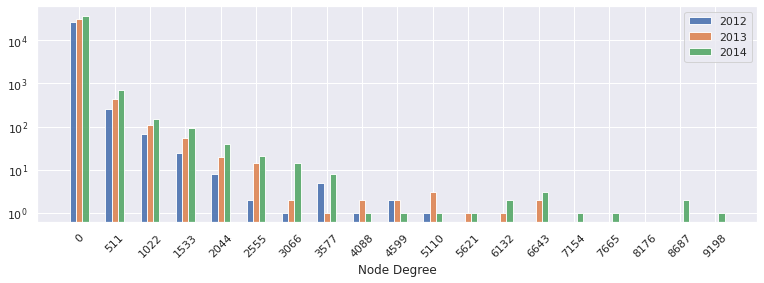

In [ ]:
import seaborn as sns
def plot_Deg_Dist(graph_fisrtYear, graph_secondYear, graph_thirdYear, step, fisrtLabel = "2014", secondLabel = "2015", ThirdLabel = "2016"):
  degs_fisrtYear = np.array(graph_fisrtYear.degree())[:,1]
  degs_secondYear = np.array(graph_secondYear.degree())[:,1]
  degs_thirdYear = np.array(graph_thirdYear.degree())[:,1]
  delta_year1 = np.max(degs_fisrtYear)//step
  delta_year2 = np.max(degs_secondYear)//step
  delta_year3 = np.max(degs_thirdYear)//step
  dist_year1 = []
  dist_year2 = []
  dist_year3 = []

  for i in range(int(step*delta_year3/delta_year1)+1):
    dist_year1.append(len(degs_fisrtYear[(degs_fisrtYear<(i+1)*delta_year1) * (degs_fisrtYear>(i)*delta_year1)]))
    dist_year2.append(len(degs_secondYear[(degs_secondYear<(i+1)*delta_year1) * (degs_secondYear>(i)*delta_year1)]))
    dist_year3.append(len(degs_thirdYear[(degs_thirdYear<(i+1)*delta_year1) * (degs_thirdYear>(i)*delta_year1)]))

  sns.set()
  width = 0.35  # the width of the bars
  x_labels_st = np.arange(0,int(step*delta_year3/delta_year1)+1)*(delta_year1)
  x_labels = np.array([str(x_) for x_ in x_labels_st])
  fig = plt.figure(figsize=(step,3))
  ax = fig.add_axes([0,0,1,1])
  ax.bar(np.arange(len(x_labels))-(width/2), np.array(dist_year1), width/2, label=fisrtLabel, alpha=0.9, log=True)
  ax.bar(np.arange(len(x_labels)), np.array(dist_year2), width/2, label=secondLabel, alpha=0.9, log=True)
  ax.bar(np.arange(len(x_labels))+(width/2), np.array(dist_year3), width/2, label=ThirdLabel, alpha=0.9, log=True)
  plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)
  plt.xlabel("Node Degree")
  plt.legend()
  fig.savefig("Deg_Dist.pdf", bbox_inches='tight')

plot_Deg_Dist(graph_year(full_dynamic_graph_sparse,2012)[0], graph_year(full_dynamic_graph_sparse,2013)[0], graph_year(full_dynamic_graph_sparse,2014)[0], 10, "2012", "2013", "2014")  

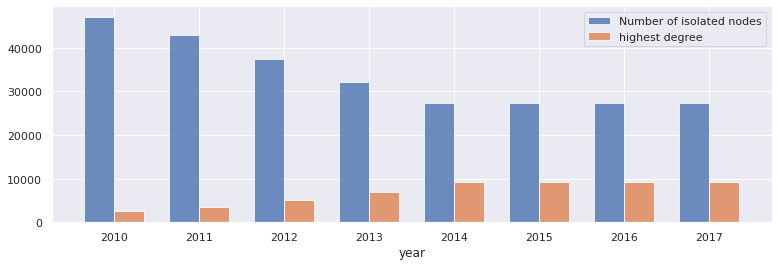

In [ ]:
def plot_isol_high_Deg(year_start, year_end):
  highDeg = []
  IsolDeg = []
  for i in range(year_start, year_end):
    graph,_,_ = graph_year(full_dynamic_graph_sparse, i)
    degs = np.array(graph.degree())[:,1]
    IsolDeg.append(sum(degs==0))
    highDeg.append(max(degs))

  x = np.arange(year_start, year_end)
  x_labels = np.array([str(x_) for x_ in x])
  sns.set()
  width = 0.35  # the width of the bars
  fig = plt.figure(figsize=(10,3))
  ax = fig.add_axes([0,0,1,1])
  ax.bar(x-width/2, IsolDeg, width, alpha=0.8, label='Number of isolated nodes')
  ax.bar(x+width/2, highDeg, width, alpha=0.8, label='highest degree')
  plt.xticks(x, x_labels)
  plt.xlabel("year")
  plt.legend()
  fig.savefig("plot_isol_high_Deg.jpeg", bbox_inches='tight')
plot_isol_high_Deg(2010,2018)  

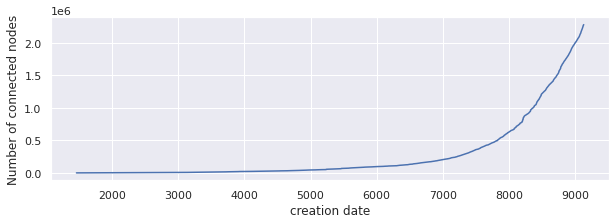

In [ ]:
def deg_sum(full_dynamic_graph_sparse):
  DegSum = []
  for i in np.unique(full_dynamic_graph_sparse[:,2]):
    DegSum.append([i, len(full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]==i])])
  DegSum = np.array(DegSum)
  fig = plt.figure(figsize=(10,3))
  plt.plot(DegSum[:,0], np.cumsum(DegSum[:,1]))
  plt.xlabel("creation date")
  plt.ylabel("Number of connected nodes")
  fig.savefig("deg_sum.jpeg", bbox_inches='tight')

deg_sum(full_dynamic_graph_sparse)

In [ ]:
rnd_vertices=random.sample(range(100),50) # we use 50 random concepts

full_idx0=[]
full_idx1=[]
for ii in range(len(rnd_vertices)): # here we will find all indices of edges where the concept is either the first or the second vertex
    full_idx0=np.concatenate((full_idx0, np.where(full_dynamic_graph_sparse[:,0] == rnd_vertices[ii])[0]))
    full_idx1=np.concatenate((full_idx1, np.where(full_dynamic_graph_sparse[:,1] == rnd_vertices[ii])[0]))

all_idx=list(set(full_idx0) & set(full_idx1))

subgraph_of_semnet=full_dynamic_graph_sparse[np.array(all_idx).astype(int)] # get the corresponding edge

# These vertices have degree(v)>0, i.e. have at least one edge in the subgraph:
rnd_vertices=list(set(list(subgraph_of_semnet[:,0])+list(subgraph_of_semnet[:,1])))
print('Number of edges in the subgraph: ', len(subgraph_of_semnet))
print('Number of non-zero degree vertices in the subgraph: ', len(rnd_vertices))

for ii in range(len(rnd_vertices)):
    subgraph_of_semnet[:,0]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,0]]
    subgraph_of_semnet[:,1]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,1]]

day_origin = date(1990,1,1)
years=[2012,2013,2014]

all_nx_nets=[]

for yy in years:
  G = graph_year(subgraph_of_semnet,yy)[0]
  all_nx_nets.append(G)

#Takes a lot of time to run!
# for idx in range(len(all_nx_nets)):
#     print('Network of the year ',years[idx])
#     curr_net=all_nx_nets[idx]
#     nx.draw(curr_net, pos=nx.spring_layout(curr_net), node_size=20)
#     plt.show()


Number of edges in the subgraph:  195
Number of non-zero degree vertices in the subgraph:  43


#Data Preprocessing

In [ ]:
import time
import random
def train_data(full_graph,year_start,years_delta,edges_used=500000,vertex_degree_cutoff=10):
  """
  :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
  :param year_start: year of graph
  :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
  :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
  :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
  
  return:
    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
  """

  years=[year_start,year_start+years_delta]    
  day_origin = date(1990,1,1)
  
  all_G=[]
  all_edge_lists=[]
  all_sparse=[]

  for i in years:
    g = graph_year(full_graph,i)
    all_G.append(g[0])
    all_edge_lists.append(g[1])
    all_sparse.append(g[2])

  all_degs=np.array(all_sparse[0].sum(0))[0]

  ## Create all edges to be predicted
  all_vertices=np.array(range(NUM_OF_VERTICES))
  vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.    

  unconnected_vertex_pairs=[]
  unconnected_vertex_pairs_solution=[]

  #create list of potential edges between node. This list has elements < edges used (= 5,00,000)
  time_start=time.time()
  while len(unconnected_vertex_pairs)<edges_used:        
    v1,v2=random.sample(range(len(vertex_large_degs)), 2) #any two nodes are randomely chosen
    if v1!=v2 and not all_G[0].has_edge(v1,v2):           #if the two random chosen nodes are not queal and not already present in the list of nodes already having edge
      if len(unconnected_vertex_pairs)%10**6==0:          
        time_end=time.time()
        print('edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M')
        time_start=time.time()
      unconnected_vertex_pairs.append((v1,v2))            #they are appended to a list which has all unconnected nodes
      unconnected_vertex_pairs_solution.append(all_G[1].has_edge(v1,v2))  #appends to list if 

        
  print('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution))
  print('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution))
  print('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution))

  unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
  unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))
  all_edge_list=np.array(all_edge_lists[0])

  return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution, all_sparse

In [ ]:
#Using all vertices as training data takes too long and requires huge amount of memory. So here we use a random subset.
edges_used=1*10**6      
vertex_degree_cutoff=10
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution,all_sparse = train_data(full_dynamic_graph_sparse, year_start-years_delta, years_delta, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

day_origin = date(1990,1,1)
years=[year_start-3,year_start-4,year_start-5]

train_sparse=[]
for yy in years:
    print('Create Graph for', yy)
    day_curr=date(yy,12,31)
    train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
    train_sparse.append(adj_mat_sparse_curr)
print('done')

edge progress ( 0.0005276203155517578 sec):  0.0 M/ 1.0 M
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  309
Ratio of vertex pairs that will be connected:  0.000309
Create Graph for 2011
Create Graph for 2010
Create Graph for 2009
done


#Train and Test Split

In [ ]:
def split_data(train_edges_for_checking,train_edges_solution):
  train_valid_test_size=[0.9, 0.1]
  x = [i for i in range(len(train_edges_for_checking))]  # random shuffle input
  random.shuffle(x)
  train_edges_for_checking = train_edges_for_checking[x]
  train_edges_solution = train_edges_solution[x]

  idx_traintest=int(len(train_edges_for_checking)*train_valid_test_size[0])
  data_edges_train=train_edges_for_checking[0:idx_traintest]
  solution_train=train_edges_solution[0:idx_traintest]  

  data_edges_test=train_edges_for_checking[idx_traintest:]
  solution_test=train_edges_solution[idx_traintest:]

  return data_edges_train, solution_train, data_edges_test, solution_test

In [ ]:
data_edges_train, solution_train, data_edges_test, solution_test = split_data(train_edges_for_checking,train_edges_solution)

In [ ]:
# Rather than using all connected and unconnected vertex pairs for training
# (i.e. needing to compute their properties), we reject about 99% of all unconnected
# examples, to have more examples of connected cases in the training. This significantly
# speeds up the computation, at the price of precision.
data_edges_train_smaller=[]
solution_train_smaller=[]
for i in range(len(data_edges_train)):
    if (solution_train[i]==0 and random.random()<0.01) or solution_train[i]==1:
        data_edges_train_smaller.append(data_edges_train[i])
        solution_train_smaller.append(solution_train[i])

#Feature Engineering

In [ ]:
def create_features(all_sparse,g1, g2, g3, AA02, AA12, AA22, all_degs0, all_degs1, all_degs2, all_degs02,all_degs12, all_degs22, pr_g1, pr_g2, pr_g3, avg_nbr_deg_1, avg_nbr_deg_2, avg_nbr_deg_3,v1,v2):

    all_properties=[]

    all_properties.append(all_degs0[v1]) # 0
    all_properties.append(all_degs0[v2]) # 1
    all_properties.append(all_degs1[v1]) # 2
    all_properties.append(all_degs1[v2]) # 3
    all_properties.append(all_degs2[v1]) # 4
    all_properties.append(all_degs2[v2]) # 5

    all_properties.append(AA02[v1,v2]) # 6
    all_properties.append(AA12[v1,v2]) # 7
    all_properties.append(AA22[v1,v2]) # 8 

    all_properties.append(all_degs02[v1]) # 9
    all_properties.append(all_degs02[v2]) # 10
    all_properties.append(all_degs12[v1]) # 11
    all_properties.append(all_degs12[v2]) # 12
    all_properties.append(all_degs22[v1]) # 13
    all_properties.append(all_degs22[v2]) # 14
 
    try:
      shortest_path_1 = len(nx.shortest_path(G=g1, source=v1, target=v2))
    except:
      shortest_path_1 = 100 
    try:
      shortest_path_2 = len(nx.shortest_path(G=g1, source=v1, target=v2))
    except:
      shortest_path_2 = 100            
    try:
      shortest_path_3 = len(nx.shortest_path(G=g1, source=v1, target=v2))
    except:
      shortest_path_3 = 100   
    all_properties.append(shortest_path_1)  #15   
    all_properties.append(shortest_path_2)  #16     
    all_properties.append(shortest_path_3)  #17  
    all_properties.append(abs(shortest_path_1-shortest_path_2))  #18 
    all_properties.append(abs(shortest_path_1-shortest_path_3))  #19
    all_properties.append(abs(shortest_path_3-shortest_path_2))  #20   

    g1_ja = list(nx.jaccard_coefficient(g1, [(v1, v2)]))[0][2]
    g2_ja = list(nx.jaccard_coefficient(g2, [(v1, v2)]))[0][2]
    g3_ja = list(nx.jaccard_coefficient(g3, [(v1, v2)]))[0][2]
    all_properties.append(g1_ja)   #21     
    all_properties.append(g2_ja)   #22  
    all_properties.append(g3_ja)   #23  

    path_cn_1 = len(list(nx.common_neighbors(g1, v1, v2)))
    path_cn_2 = len(list(nx.common_neighbors(g2, v1, v2)))
    path_cn_3 = len(list(nx.common_neighbors(g3, v1, v2)))  
    all_properties.append(path_cn_1)  #24
    all_properties.append(path_cn_2)  #25
    all_properties.append(path_cn_3)  #26
    all_properties.append(abs(path_cn_1-path_cn_2)) #27
    all_properties.append(abs(path_cn_1-path_cn_3)) #28
    all_properties.append(abs(path_cn_2-path_cn_3)) #29

    pr1 = pr_g1[v1] + pr_g1[v2]
    pr2 = pr_g2[v1] + pr_g2[v2]
    pr3 = pr_g3[v1] + pr_g3[v2]
    all_properties.append(pr1)  #30
    all_properties.append(pr2)  #31
    all_properties.append(pr3)  #32
    all_properties.append(abs(pr1-pr2)) #33
    all_properties.append(abs(pr1-pr3)) #34
    all_properties.append(abs(pr3-pr2)) #35

    sum_avg_nbr_deg_1 = avg_nbr_deg_1[v1] + avg_nbr_deg_1[v2]
    sum_avg_nbr_deg_2 = avg_nbr_deg_2[v1] + avg_nbr_deg_2[v2]
    sum_avg_nbr_deg_3 = avg_nbr_deg_3[v1] + avg_nbr_deg_3[v2]
    all_properties.append(sum_avg_nbr_deg_1)  #36
    all_properties.append(sum_avg_nbr_deg_2)  #37
    all_properties.append(sum_avg_nbr_deg_3)  #38
    all_properties.append(abs(sum_avg_nbr_deg_1-sum_avg_nbr_deg_2)) #39
    all_properties.append(abs(sum_avg_nbr_deg_1-sum_avg_nbr_deg_3)) #40
    all_properties.append(abs(sum_avg_nbr_deg_3-sum_avg_nbr_deg_2)) #41
    
    return all_properties

def create_features_list(all_sparse,vlist):
    all_properties=[]

    g1 = nx.from_scipy_sparse_matrix(all_sparse[0])
    g2 = nx.from_scipy_sparse_matrix(all_sparse[1])
    g3 = nx.from_scipy_sparse_matrix(all_sparse[2])

    all_degs0=np.array(all_sparse[0].sum(0))[0]
    if np.max(all_degs0)>0:
        all_degs0=all_degs0/np.max(all_degs0)
    all_degs1=np.array(all_sparse[1].sum(0))[0]
    if np.max(all_degs1)>0:
        all_degs1=all_degs1/np.max(all_degs1)
    all_degs2=np.array(all_sparse[2].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs2=all_degs2/np.max(all_degs2)  

    AA02=all_sparse[0]**2
    AA02=AA02/AA02.max()
    AA12=all_sparse[1]**2
    AA12=AA12/AA12.max()
    AA22=all_sparse[2]**2
    AA22=AA02/AA22.max()

    all_degs02=np.array(AA02[0].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs02=all_degs02/np.max(all_degs02)
    all_degs12=np.array(AA12[1].sum(0))[0]
    if np.max(all_degs12)>0:
        all_degs12=all_degs12/np.max(all_degs12)
    all_degs22=np.array(AA22[2].sum(0))[0]
    if np.max(all_degs22)>0:
        all_degs22=all_degs22/np.max(all_degs22)

    pr_g1 = nx.pagerank(g1)        
    pr_g2 = nx.pagerank(g2)
    pr_g3 = nx.pagerank(g3)

    avg_nbr_deg_1 = nx.average_neighbor_degree(g1)
    avg_nbr_deg_2 = nx.average_neighbor_degree(g2)
    avg_nbr_deg_3 = nx.average_neighbor_degree(g3)    
  
    for i in range(len(vlist)):
      vals=create_features(all_sparse,
                           g1, g2, g3,
                           AA02, AA12, AA22,
                           all_degs0, all_degs1, all_degs2,
                           all_degs02,all_degs12, all_degs22,
                           pr_g1, pr_g2, pr_g3,
                           avg_nbr_deg_1, avg_nbr_deg_2, avg_nbr_deg_3,
                           vlist[i][0], vlist[i][1])
      all_properties.append(vals)

    return all_properties

cols = ["all_degs0[v1]", "all_degs0[v2]", "all_degs1[v1]", "all_degs1[v2]", "all_degs2[v1]", "all_degs2[v2]",
            "AA02[v1,v2]", "AA12[v1,v2]", "AA22[v1,v2]",
            "all_degs02[v1]", "all_degs02[v2]", "all_degs12[v1]", "all_degs12[v2]", "all_degs22[v1]", "all_degs22[v2]",
            "shortest_path_1", "shortest_path_2", "shortest_path_3", "diff_shortest_path_1_2", "diff_shortest_path_1_3", "diff_shortest_path_3_2", 
            "g1_ja", "g2_ja", "g3_ja",
            "path_cn_1", "path_cn_2", "path_cn_3", "diff_path_cn_1_2", "diff_path_cn_1_3", "diff_path_cn_3_2",
            "pr1", "pr2", "pr3", "diff_pr_1_2", "diff_pr_1_3", "diff_pr_3_2",
            "sum_and_1", "sum_and_2", "sum_and_3", "diff_sum_and_1_2", "diff_sum_and_1_3", "diff_sum_and_3_2"
            ]

In [ ]:
# Rather than using all connected and unconnected vertex pairs for training
# (i.e. needing to compute their properties), we reject about 99% of all unconnected
# examples, to have more examples of connected cases in the training. This significantly
# speeds up the computation, at the price of precision.
data_edges_train_smaller=[]
solution_train_smaller=[]
for ii in range(len(data_edges_train)):
    if (solution_train[ii]==0 and random.random()<0.01) or solution_train[ii]==1:
        data_edges_train_smaller.append(data_edges_train[ii])
        solution_train_smaller.append(solution_train[ii])

data_train=create_features_list(train_sparse,data_edges_train_smaller)

data_train0=[]
data_train1=[]
for ii in range(len(data_edges_train_smaller)):
    if solution_train_smaller[ii]==1:
        data_train1.append(data_train[ii])
    else:
        data_train0.append(data_train[ii])

data_test=create_features_list(train_sparse,data_edges_test)
data_test0=[]
data_test1=[]
for ii in range(len(data_edges_test)):
    if solution_test[ii]==1:
        data_test1.append(data_test[ii])
    else:
        data_test0.append(data_test[ii])
print('done')

done


#Modeling & Evaluation

In [ ]:
import pandas as pd
X_train = data_train
y_train = solution_train_smaller
df_train = pd.DataFrame(X_train, y_train,columns=cols)

X_test = data_test
y_test = solution_test
df_test = pd.DataFrame(X_test, y_test, columns=cols)

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf_clf=RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train,y_train)
y_pred=rf_clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9918


No handles with labels found to put in legend.


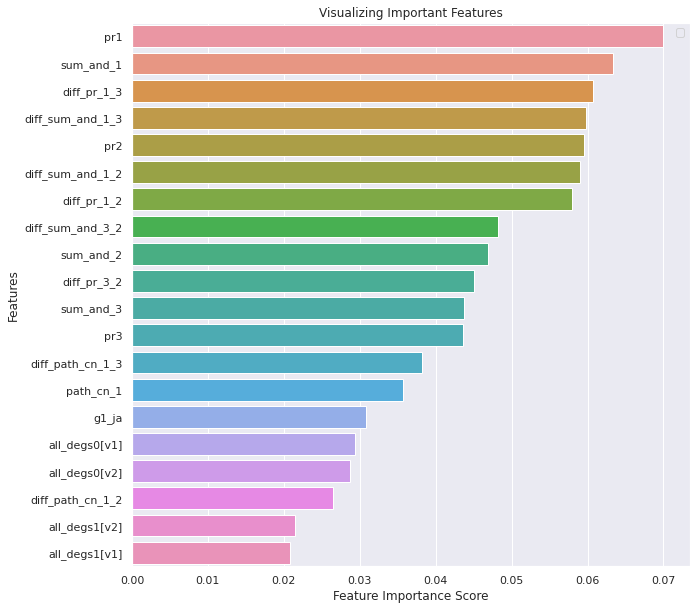

In [ ]:
feature_imp = pd.Series(rf_clf.feature_importances_,index=df_train.columns).sort_values(ascending=False)[:20]
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

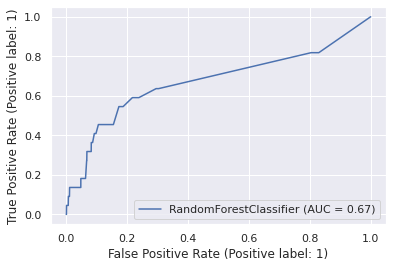

In [ ]:
from sklearn.metrics import RocCurveDisplay
rf_disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)
plt.show()

##Catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 44 kB/s 


In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2,
                           eval_metric='Accuracy')

model.fit(X_train, y_train)
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
preds_raw = model.predict(y_test)


0:	learn: 0.9704893	total: 6.11ms	remaining: 6.11ms
1:	learn: 0.9710318	total: 9.29ms	remaining: 0us


In [ ]:
from catboost.utils import eval_metric
print("Accuracy : ", eval_metric(list(y_test), preds_proba, "Accuracy")[0])

Accuracy :  0.99424


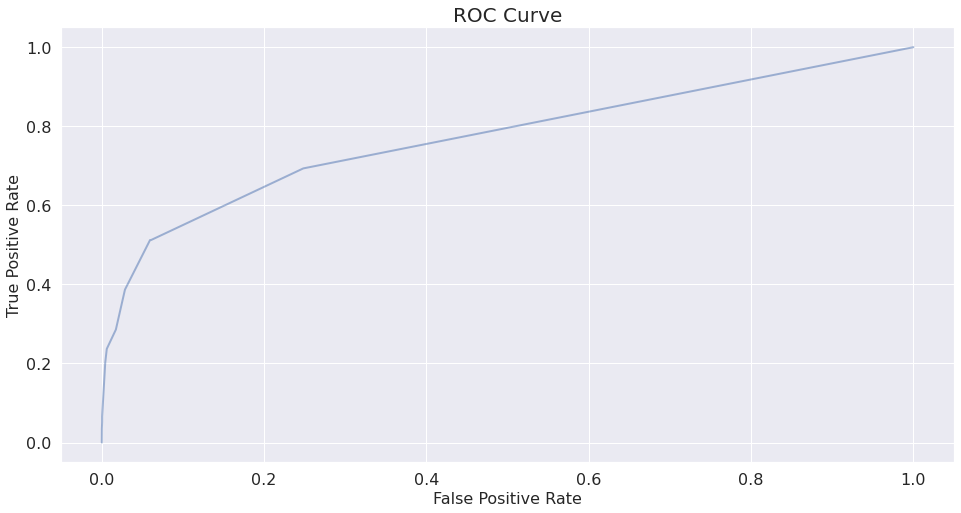

AUC value =  0.6255737625914065


In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve, eval_metric
catboost_pool = Pool(df_train, y_train)
auc_cat = get_roc_curve(model, catboost_pool,thread_count=-1,plot=True)
catboost_auc = eval_metric(y_test, preds_proba, 'AUC')[0]
print("AUC value = ",catboost_auc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


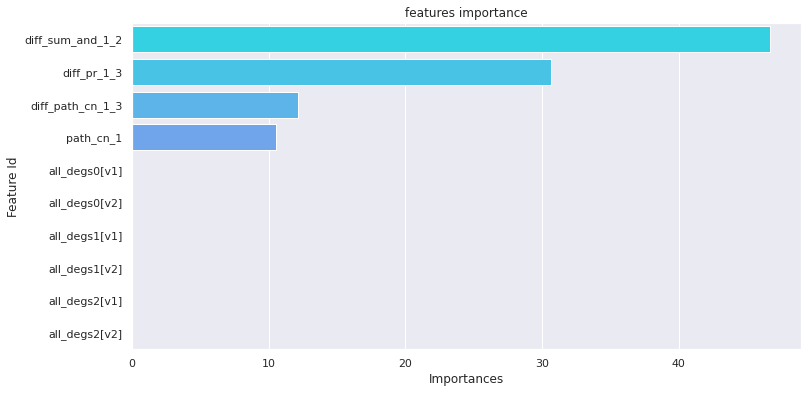

In [ ]:
df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True))[:10]
k=0
for i in df_feature_importance["Feature Id"]:
  df_feature_importance["Feature Id"][k] = cols[int(i)]
  k=k+1
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance');

# feature_imp = pd.Series(rf_clf.feature_importances_,index=df_train.columns).sort_values(ascending=False)[:20]
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.barplot(x=feature_imp, y=feature_imp.index)


##LightGBM

Accuracy: 0.99166


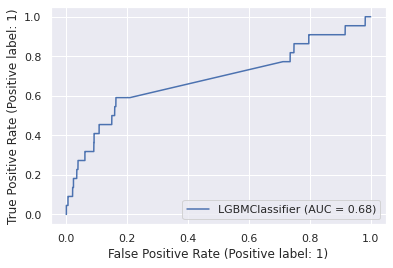

In [ ]:
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier(learning_rate=0.03,random_state=42,boosting_type="gbdt",n_estimators=400)
clf_lgbm.fit(df_train, y_train)
pred = clf_lgbm.predict(df_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred))
lgb_disp = RocCurveDisplay.from_estimator(clf_lgbm, df_test, y_test)
plt.show()

##SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
clf_SGD = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf_SGD.fit(df_train, y_train)
pred = clf_SGD.predict(df_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred))


Accuracy: 0.99978


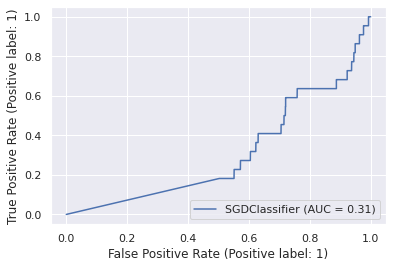

In [ ]:
sgd_disp = RocCurveDisplay.from_estimator(clf_SGD, df_test, y_test)
plt.show()

##Fully Connected Neural Network

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([287])) that is different to the input size (torch.Size([287, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(i

0 - train:  0.9981277 ; test:  0.84518445
50 - train:  0.40677586 ; test:  0.46137604
100 - train:  0.36550355 ; test:  0.4204532
Early stopping kicked in


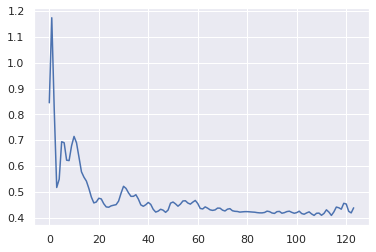

done


In [ ]:
class ff_network(nn.Module):
  #Fully Connected layers
  def __init__(self):
    super(ff_network, self).__init__()
    self.semnet = nn.Sequential( # very small network for tests
                                nn.Linear(42, 100), # 15 properties
                                nn.ReLU(),
                                nn.Linear(100, 100), 
                                nn.ReLU(),       
                                nn.Linear(100, 10),
                                nn.ReLU(),               
                                nn.Linear(10, 1)
                               )
  def forward(self, x):
    res = self.semnet(x)
    return res


def train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    size_of_loss_check=2000
    
    optimizer_predictor = torch.optim.Adam(model_semnet.parameters(), lr=lr_enc)
    
    data_train0=torch.tensor(data_train0, dtype=torch.float).to(device)
    data_test0=torch.tensor(data_test0, dtype=torch.float).to(device)
    
    data_train1=torch.tensor(data_train1, dtype=torch.float).to(device)
    data_test1=torch.tensor(data_test1, dtype=torch.float).to(device)

    test_loss_total=[]
    moving_avg=[]
    criterion = torch.nn.MSELoss()
    
    '''
    There are much more vertex pairs that wont be connected (0) rather than ones
    that will be connected (1). However, we observed that training with an equally weighted
    training set (same number of examples for (0) and (1)) results in more stable training.
    
    For that reason, we dont have true 'episodes' (where each example from the training set
    has been used in the training). Rather, in each of our iteration, we sample batch_size
    random training examples from data_train0 and from data_train1.
    '''
    for iteration in range(500000): 
        model_semnet.train()
        data_sets=[data_train0,data_train1]
        total_loss=0
        for idx_dataset in range(len(data_sets)):
            idx = torch.randint(0, len(data_sets[idx_dataset]), (batch_size,))
            data_train_samples = data_sets[idx_dataset][idx]
            calc_properties = model_semnet(data_train_samples)
            curr_pred=torch.tensor([idx_dataset] * batch_size, dtype=torch.float).to(device)
            real_loss = criterion(calc_properties, curr_pred)
            total_loss += torch.clamp(real_loss, min = 0., max = 50000.).double()

        optimizer_predictor.zero_grad()
        total_loss.backward()
        optimizer_predictor.step()

        # Evaluating the current quality.
        with torch.no_grad():
            model_semnet.eval()
            # calculate train set
            eval_datasets=[data_train0,data_train1,data_test0,data_test1]
            all_real_loss=[]
            for idx_dataset in range(len(eval_datasets)):
                eval_datasets[idx_dataset]
                calc_properties = model_semnet(eval_datasets[idx_dataset][0:size_of_loss_check])        
                curr_pred=torch.tensor([idx_dataset%2] * len(eval_datasets[idx_dataset][0:size_of_loss_check]), dtype=torch.float).to(device)
                real_loss = criterion(calc_properties, curr_pred)
                all_real_loss.append(real_loss.detach().cpu().numpy())
             
            test_loss_total.append(np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))

            if iteration%50==0:
                print(str(iteration)+' - train: ',np.mean(all_real_loss[0])+np.mean(all_real_loss[1]),'; test: ',np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))


            if len(test_loss_total)>100: # early stopping
                test_loss_moving_avg=sum(test_loss_total[-50:])
                moving_avg.append(test_loss_moving_avg)
                if len(moving_avg)>10:
                    if moving_avg[-1]>moving_avg[-2] and moving_avg[-1]>moving_avg[-10]:
                        print('Early stopping kicked in')
                        break

    plt.plot(test_loss_total)
    plt.show()

    return True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_semnet = ff_network().to(device)

batch_size=100 # Large batch_size seems to be important
lr_enc=5*10**-4

model_semnet.train()
train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size)  
print('done')

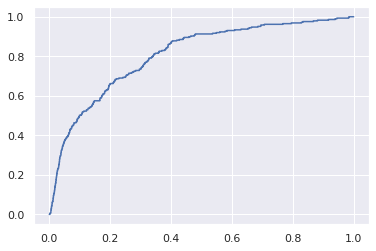

    AUC_train:  0.8073795022064948


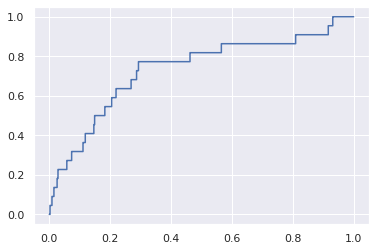

    AUC_test:  0.7329126044098646


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_ROC(data_vertex_pairs,data_solution):
    data_solution=np.array(data_solution)
    data_vertex_pairs_sorted=data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
        # # # # # # # # # # # # # # # 
        # 
        # We normalize the ROC curve such that it starts at (0,0) and ends at (1,1).
        # Then our final metric of interest is the Area under that curve.
        # AUC is between [0,1].
        # AUC = 0.5 is acchieved by random predictions
        # AUC = 1.0 stands for perfect prediction.
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    
    plt.plot(xpos, ypos)
    plt.show()
    
    AUC=sum(ROC_vals)/len(ROC_vals)
    return AUC

data_train=torch.tensor(data_train, dtype=torch.float).to(device)
all_predictions_train=flatten(model_semnet(data_train).detach().cpu().numpy())
sorted_predictions_train=np.flip(np.argsort(all_predictions_train,axis=0))    
AUC_train=calculate_ROC(sorted_predictions_train, solution_train_smaller)
print('    AUC_train: ', AUC_train)

data_test=torch.tensor(data_test, dtype=torch.float).to(device)
all_predictions_test=flatten(model_semnet(data_test).detach().cpu().numpy())
sorted_predictions_test=np.flip(np.argsort(all_predictions_test,axis=0))    
AUC_test=calculate_ROC(sorted_predictions_test, solution_test)
print('    AUC_test: ', AUC_test)